In [67]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import sys
sys.path.append('..')
import scipy.optimize as opt

In [13]:
from models.seir_opt import SEIR

In [63]:
def calculate_opt(x):
    R0 = 2.2 
    T_inf = 2.9
    T_trans = T_inf/R0
    T_inc = 5.2
    T_recov_mild = (14 - T_inf)
    T_hosp = 5
    T_recov_severe = (31.5 - T_inf)
    T_death = 32

    P_severe = 0.2
    P_fatal = 0.02
    P_mild = 1 - P_severe - P_fatal

    N = 7e6
    I0 = 1.0

    # new_R0 = 0.74
    # intervention_amount = R0/new_R0
    intervention_day = x[1]
    intervention_amount = 3
    intervention_duration = x[0]

    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, intervention_day, intervention_amount, intervention_duration]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=200)
    states_int_array = (sol.y*N).astype('int')
    
    E = states_int_array[1]
    I = states_int_array[2]
    H = states_int_array[5]
    F = states_int_array[8]
    
    objective = N*intervention_duration*0.8 + 1e5 + F[-1]*1e4 + np.sum(H)
    return(objective/1e8)

In [76]:
res = opt.minimize(calculate_opt, [50,100], method='nelder-mead',options={'xatol': 1e0, 'disp': True, 'fatol': 1e-2, 'maxiter': 1e4, 'maxfev': 1e4})

Optimization terminated successfully.
         Current function value: 4.035611
         Iterations: 21
         Function evaluations: 45


In [77]:
res

 final_simplex: (array([[66.58691406, 62.79296875],
       [66.72027588, 62.67456055],
       [66.73950195, 62.74902344]]), array([4.03561134, 4.0430796 , 4.04415626]))
           fun: 4.0356113375
       message: 'Optimization terminated successfully.'
          nfev: 45
           nit: 21
        status: 0
       success: True
             x: array([66.58691406, 62.79296875])

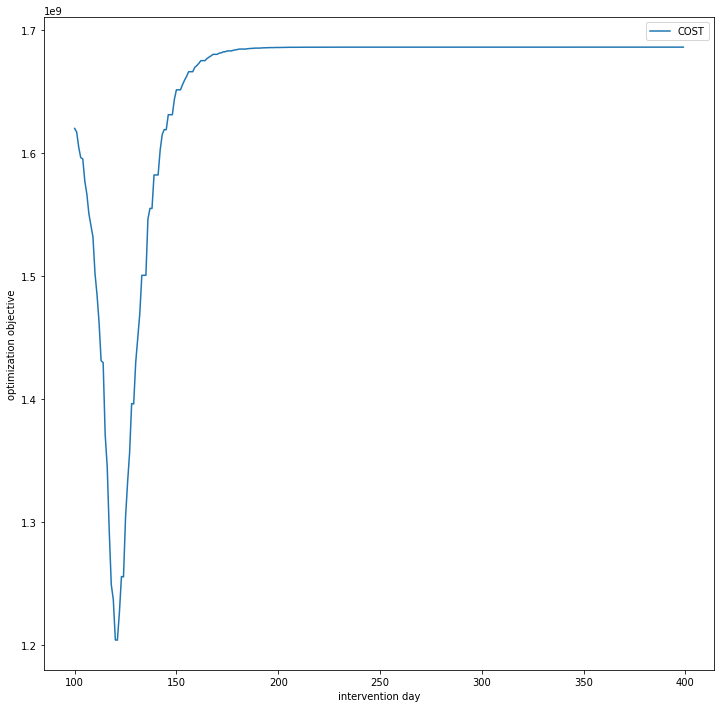

In [56]:
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(12, 12))
plt.plot(ind+100, objective, label='COST')
plt.ylabel('optimization objective')
plt.xlabel('intervention day')
plt.legend()
plt.show()

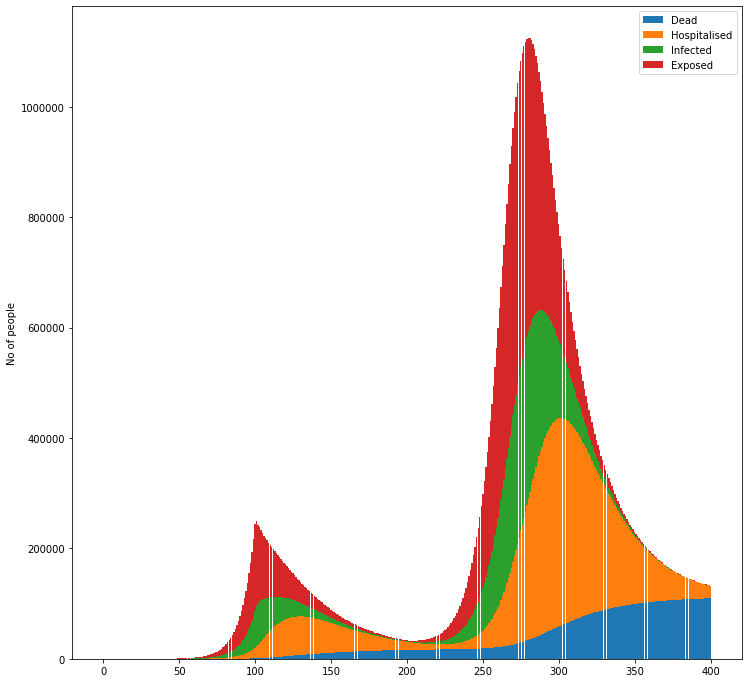

In [51]:
ind = sol.t    # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12, 12))
p1 = plt.bar(ind, F, width)
p2 = plt.bar(ind, H, width, bottom=F)
p3 = plt.bar(ind, I, width, bottom=H+F)
p4 = plt.bar(ind, E, width, bottom=I+H+F)
plt.ylabel('No of people')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Dead', 'Hospitalised', 'Infected', 'Exposed'))

plt.show()